In [1]:
import mne
import os.path as op
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#data_path = op.join('C:/Users/csilv/Desktop/UNB Gama/7 Semestre/Processamento de Sinais/Normal_Subject_01.edf') #Define data_path
#data_path = op.join('D:/My Drive/Estudos/Engenharia Eletrônica - UnB/7º semestre/Processamento de Sinais/Projeto Final/Dataset/Normal_Subject_01.edf')
data_path = op.join('C:/Users/ASUS/OneDrive/UnB/7º semestre/Processamento de Sinais/Normal_Subject_01.edf')
raw = mne.io.read_raw_edf(data_path) #read raw data

Extracting EDF parameters from C:\Users\ASUS\OneDrive\UnB\7º semestre\Processamento de Sinais\Normal_Subject_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
raw.info['chs'][0]['kind'] = 202
raw.info['chs'][1]['kind'] = 202
raw.info['chs'][2]['kind'] = 202
raw.info['chs'][3]['kind'] = 202
raw.info['chs'][18]['kind'] = 202
raw.info['chs'][19]['kind'] = 202

In [4]:
raw.info['bads'] = ['EMG', 'EMG1', 'EMG2', 'ECGII']

In [5]:
picks = mne.pick_types(raw.info, eeg=True, eog= True, exclude = raw.info['bads'])

In [ ]:
without_filter = raw.plot_psd(fmax = 60)

In [6]:
raw.load_data()
raw.notch_filter(np.arange(50, 100, 50), picks=picks, fir_design='firwin') #notch filter at 50, 100, 150 and 200

Reading 0 ... 7366399  =      0.000 ... 28774.996 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)



<RawEDF  |  Normal_Subject_01.edf, n_channels x n_times : 24 x 7366400 (28775.0 sec), ~1.32 GB, data loaded>

In [ ]:
#notch_filter = raw.plot_psd(area_mode='range', picks=picks, average=False, tmax=10.0)

In [7]:
raw.filter(None, 40., picks=picks, fir_design='firwin') # low pass filtering below 40 Hz'
#low_pass_filter = raw.plot_psd(area_mode='range', picks=picks, average=False, tmax=10.0)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 85 samples (0.332 sec)



<RawEDF  |  Normal_Subject_01.edf, n_channels x n_times : 24 x 7366400 (28775.0 sec), ~1.32 GB, data loaded>

In [8]:
raw.filter(1., None, picks=picks, fir_design='firwin') #high pass filtering above 1Hz
#high_pass_filter = raw.plot_psd(area_mode='range', picks=picks, average=False, tmax=10.0)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



<RawEDF  |  Normal_Subject_01.edf, n_channels x n_times : 24 x 7366400 (28775.0 sec), ~1.32 GB, data loaded>

In [ ]:
raw.info['ch_names']

In [9]:
events = mne.make_fixed_length_events(raw, duration = 30.)

In [10]:
reject = dict(eeg = 150e-6, eog = 250e-6)

In [11]:
epochs = mne.Epochs(raw, events=events, picks=picks, reject=None, preload=True, tmin=-1.5, tmax=1.5) #Define trials

959 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 959 events and 769 original time points ...
1 bad epochs dropped


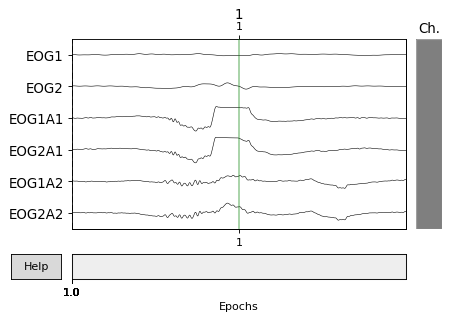

In [12]:
top = epochs[4].plot(picks=['EOG1A1', 'EOG1A2', 'EOG2A1', 'EOG2A2', 'EOG1', 'EOG2'])

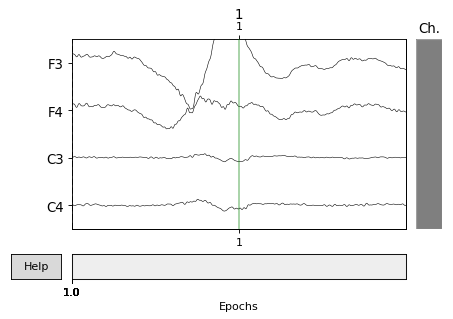

In [184]:
# 1. Decompose the data onto a set of components (i.e., rotate to new axes) using a BSS algorithm.

no_plot = epochs[4].plot(picks=['F3', 'F4', 'C3', 'C4'])

In [13]:
toSobi = epochs[4].get_data()

In [ ]:
toSobi.shape

In [14]:
# %load sobi.py
import numpy as np
import itertools
import random

def time_lagged_cov(X, num_lags):

    N = X.shape[0]
    L = X.shape[1] - num_lags
    R = np.empty([num_lags,N,N])

    center = lambda x: x-x.mean(1)[:,None]

    X0 = center(X[:, 0:(0+L)])
    
    for k in range(num_lags):
        Xk = center(X[:,k:(k+L)])
        R[k] = (1.0/L)*(X0.dot(Xk.T))
        R[k] = 0.5*(R[k] + R[k].T)

    return R


def prewhiten(X):

    # subtract mean
    Xw = X - X.mean(1)[:, None]

    # Compute SVD
    U,s,V = np.linalg.svd(Xw, full_matrices=False)
    Sinv = np.linalg.pinv(np.diag(s))

    # Find principal components
    Q  = np.dot(Sinv, U.T)
    Xw = Q.dot(X)

    return Q, Xw


def submat_mul(X, i, j, R, multype='post'):

    if multype.lower() == 'post':
        idx_i = (..., i)
        idx_j = (..., j)
    elif multype.lower() == 'pre':
        idx_i = (..., i, slice(None))
        idx_j = (..., j, slice(None))

     # In place multiplication X*R
    col_i = X[idx_i]*1.0
    col_j = X[idx_j]*1.0
    X[idx_i] = R[0,0]*col_i + R[0,1]*col_j
    X[idx_j] = R[1,0]*col_i + R[1,1]*col_j

    return X

def max_eigvec(A):
    # Find eigenvector associated with largest eigenvalue
    [eigvals,v] = np.linalg.eigh(A)
    v = v[:,-1]
    return v

def generate_index_pairs(idx_range, random_order=True):
    ij_pairs = itertools.combinations(idx_range, 2)
    ij_pairs = list(ij_pairs)
    if random_order:
        random.shuffle(ij_pairs)
    
    return ij_pairs

def off(X):
    off_ = 0
    for x in X:
        off_ += (np.linalg.norm(x,ord='fro')**2 - np.linalg.norm(np.diag(x))**2)

    return off_/np.max(X)

def jd(X, eps=1.0e-6, random_order = True):

    """jointly diagonalize several matrices.

    Performs jacobi-like procedure to approximately diagonalize
    a set of matrices X

    Parameters
    ----------
    X : np.ndarray
        Has dimensions [num_matrices, num_rows, num_cols]
    eps : scalar, optional
        Stopping criterion based on eps tolerance, should be between 0 and infinity
    random_order : bool, optional
        If True, pivots will cycle randomly for givens rotations.
        May affect convergence rate but not the final soltuion

    Returns
    -------
    V : np.ndarray
        2D array containing diagonalizing transformation
        i.e. (V.T).dot( X ).dot( V ) will be approximately diagonal
    
    """

    X = np.atleast_3d(X)
    V = np.eye(X.shape[1])

    keep_going = True
    counter = 0
    off_val = []
    while keep_going:
        print('{}: {}'.format(counter, off(X)))
        counter += 1
        keep_going = False

        ij_pairs = generate_index_pairs(range(X.shape[1]), 
                                        random_order = random_order)
        
        for (i,j) in ij_pairs:
            # Extract submatrix
            idx = (slice(None), ) + np.ix_([i,j],[i,j])
            A = X[idx]*1.0

            # Find givens rotation matrix
            R = find_givens_rotation(A)

            if abs(R[0,1]) > eps: # sin_theta = R[0,1]
                keep_going = True 
                # Update X and V matrices

                # X' = R^T X R
                X = submat_mul(X, i, j, R, multype='post')
                X = submat_mul(X, i, j, R, multype='pre')

                # V = V R
                V = submat_mul(V, i, j, R, multype='post')

    return V

def find_givens_rotation(A):

    """
    Belouchrani, A., et al. “A Blind Source Separation Technique Using 
    Second-Order Statistics.” IEEE Transactions on Signal Processing: 
    A Publication of the IEEE Signal Processing Society, vol. 45, 
    no. 2, Feb. 1997, pp. 434–44, doi:10.1109/78.554307.

    See Appendix A
    """
    G   = np.array( [ A[:,0,0] - A[:,1,1], A[:,0,1] + A[:,1,0] ] )
    G   = np.atleast_2d(G).T
    GHG = np.dot(G.T, G)
    v = max_eigvec(GHG)
    
    v = np.sign(v[0])*v
    cos_theta = np.sqrt(0.5 + 0.5*v[0])
    sin_theta = -0.5*v[1]/(cos_theta)

    R = np.array([[ cos_theta,  -sin_theta],
                    [ sin_theta, cos_theta]])

    return R

def sobi(X, num_lags=None, eps=1.0e-6, random_order = True):

    """blind source separation technique using SOBI algorithm

    The "second-order blind source idenitification" algorithm is 
    a blind-source separation technique that works by jointly diagonalizing
    a set of time-lagged covariance matrices. 

    Parameters
    ----------
    X : np.ndarray
        Has dimensions [num_signals, num_samples]
    num_lags : int
        Number of time-lags to use in forming covariance matrices
    eps : scalar, optional
        Stopping criterion based on eps tolerance, should be between 0 and infinity
    random_order : bool, optional
        If True, pivots will cycle randomly for givens rotations.
        May affect convergence rate but not the final soltuion

    Returns
    -------
    S : np.ndarray
        2D array containing estimated source signals
    
    A : np.ndarray
        2D array containing mixing matrix
        i.e. A.dot(S) = X
    
    W : np.ndarray
        2D array containing unmixing matrix
        i.e. W.dot(X) = S
    
    """

    if num_lags is None:
        num_lags = np.minimum(1000, int(X.shape[1]/2))

    Q, Xw = prewhiten(X)

    R = time_lagged_cov(Xw, num_lags)

    V = jd(R*1.0, eps=eps)

    W = (V.T).dot(Q)
    A = np.linalg.pinv(W)
    S = W.dot(X)

    return S, A, W


    
    




In [15]:
[S, A, W] = sobi(toSobi[0])

0: 1.0395053622481931
1: 0.8845898606986939
2: 0.8811412694072166
3: 0.9128503434695111
4: 0.9237280647157229
5: 0.9281417624831202
6: 0.926213098156889
7: 0.9245143958143512
8: 0.9240294754675438
9: 0.9236326712195526
10: 0.9228071731395974
11: 0.9216417917886635
12: 0.921392245149832
13: 0.9205443807654247
14: 0.9198559984651627
15: 0.9188951962536922
16: 0.918230094219405
17: 0.9176753234220133
18: 0.9173254075961029
19: 0.9169292425123247
20: 0.916354367039187
21: 0.9162993630407164
22: 0.9158946591866595
23: 0.9156248006278923
24: 0.9153566334130305
25: 0.9151531355570228
26: 0.9150619168066283
27: 0.9150452943818157
28: 0.9149086577564677
29: 0.9148020245977159
30: 0.9146842759612387
31: 0.9146207686710728
32: 0.914523983377327
33: 0.9144715126018992
34: 0.9143774385374748
35: 0.9143030383806674
36: 0.9143046408746267
37: 0.9142679600816871
38: 0.9142311911370319
39: 0.9142041521994926
40: 0.9141829083703729
41: 0.9141392709080258
42: 0.9141206133847368
43: 0.9140943017938741
44:

In [16]:
S.shape

(20, 769)

In [ ]:
plt.plot(S[6])

In [ ]:
plt.plot(toSobi[0][6])

In [ ]:
# 2. Reverse the sign on all lower and horizontal EOG channels (i.e., multiply signals by  1)
# and again decompose data onto components using a BSS algorithm. Flag those components that invert.

epochs.ch_names

In [17]:
EOG_ch=[0, 1, 2, 3, 14, 15]

In [ ]:
EOG_ch.type

In [18]:
for n in EOG_ch:
    print(epochs.ch_names[n])

EOG1
EOG2
EOG1A1
EOG2A1
EOG1A2
EOG2A2


In [19]:
inv_EOG=epochs[4].get_data()

In [ ]:
inv_EOG.shape

In [20]:
inv_EOG[0][EOG_ch] = -inv_EOG[0][EOG_ch]

In [21]:
[S_new, A_new, W_new] = sobi(inv_EOG[0])

0: 1.0395053622481931
1: 0.8998420527151569
2: 0.8846984006458356
3: 0.8850739206364686
4: 0.8889579677633589
5: 0.8903501157084829
6: 0.8929829111521033
7: 0.8930213461803007
8: 0.8988242774283648
9: 0.9022404434518313
10: 0.9073701664169391
11: 0.9117827487039483
12: 0.9168594451548517
13: 0.9208469986337248
14: 0.9263768700972934
15: 0.9286115882008502
16: 0.9325983399313845
17: 0.9345916754490514
18: 0.9381393000426007
19: 0.941285480067648
20: 0.9439745917605852
21: 0.9468254087686592
22: 0.9484103247153237
23: 0.9514124570474154
24: 0.9527169897290925
25: 0.9546605364014572
26: 0.956427805818018
27: 0.957757283611187
28: 0.9595616912500436
29: 0.9605752806220823
30: 0.9620382779771269
31: 0.9632240589388746
32: 0.9648546730250456
33: 0.9656679618555438
34: 0.9665693022504139
35: 0.9674833805263453
36: 0.9684701744811655
37: 0.9690061955416107
38: 0.9696560822433177
39: 0.9703716133657092
40: 0.9708694222843508
41: 0.9715534067126438
42: 0.9719966632139746
43: 0.9726010511748846
4

In [ ]:
plt.plot(S_new[6])


In [ ]:
plt.plot(inv_EOG[0][6])

CORRELATION

In [22]:
#será utilizado a função de correlação do scipy
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
raw.info['ch_names']

In [23]:
EOG = np.zeros((6,769),dtype= float) #Lista de EOG
EOG[0] = S_new[0]
EOG[1] = S_new[1]
EOG[2] = S_new[2]
EOG[3] = S_new[3]
EOG[4] = S_new[14]
EOG[5] = S_new[15]

In [24]:
COMP = np.zeros((14,769), dtype = float) #Lista dos outros componentes
COMP[0] = S_new[4]
COMP[1] = S_new[5]
COMP[2] = S_new[6]
COMP[3] = S_new[7]
COMP[4] = S_new[8]
COMP[5] = S_new[9]
COMP[6] = S_new[10]
COMP[7] = S_new[11]
COMP[8] = S_new[12]
COMP[9] = S_new[13]
COMP[10] = S_new[16]
COMP[11] = S_new[17]
COMP[12] = S_new[18]
COMP[13] = S_new[19]


In [25]:
x = signal.correlate(COMP[0], EOG[0], 'same')
x.shape

(769,)

In [169]:
corr_eog1 = np.zeros((14,769), dtype = float)
for i in range(14):
    corr_eog1[i] = signal.correlate(EOG[0], COMP[i], mode = 'same')

In [170]:
corr_eog2 = np.zeros((14,769), dtype = float)
for i in range(14):
    corr_eog2[i] = signal.correlate(EOG[1], COMP[i], mode = 'same')

In [171]:
corr_eog1a1 = np.zeros((14,769), dtype = float)
for i in range(14):
    corr_eog1a1[i] = signal.correlate(EOG[2], COMP[i], mode = 'same')

In [172]:
corr_eog1a2 = np.zeros((14,769), dtype = float)
for i in range(14):
    corr_eog1a2[i] = signal.correlate(EOG[3], COMP[i], mode = 'same')

In [173]:
corr_eog2a1 = np.zeros((14,769), dtype = float)
for i in range(14):
    corr_eog2a1[i] = signal.correlate(EOG[4], COMP[i], mode = 'same')

In [174]:
corr_eog2a2 = np.zeros((14,769), dtype = float)
for i in range(14):
    corr_eog2a2[i] = signal.correlate(EOG[5], COMP[i], mode = 'same')

In [93]:
CORRELATION = np.zeros((84,769), dtype = float) #Lista de cross correlation
t = np.arange(0,769,1)
#fig, (correlation1,correlation2,correlation3, correlation4, correlation5, correlation6 ) = plt.subplots(6, 1, sharex=True, figsize=[15, 30])
for i in range(6):
    for k in range(14):
        if i == 0:
            CORRELATION[k] = signal.correlate(EOG[i], COMP[k], mode = 'same')
            #correlation1.plot(t, CORRELATION[k])
        if i == 1:
            CORRELATION[14 + k] = signal.correlate(EOG[i], COMP[k], mode = 'same')
            #correlation2.plot(t, CORRELATION[14 + k])
        if i == 2:
            CORRELATION[28 + k] = signal.correlate(EOG[i], COMP[k], mode = 'same')
            #correlation3.plot(t, CORRELATION[28 + k])
        if i == 3:
            CORRELATION[42 + k] = signal.correlate(EOG[i], COMP[k], mode = 'same')
            #correlation4.plot(t, CORRELATION[42 + k])
        if i == 4:
            CORRELATION[56 + k] = signal.correlate(EOG[i], COMP[k], mode = 'same')
            #correlation5.plot(t, CORRELATION[56 + k])
        if i == 5:
            CORRELATION[70 + k] = signal.correlate(EOG[i], COMP[k], mode = 'same')
            #correlation6.plot(t, CORRELATION[70 + k])

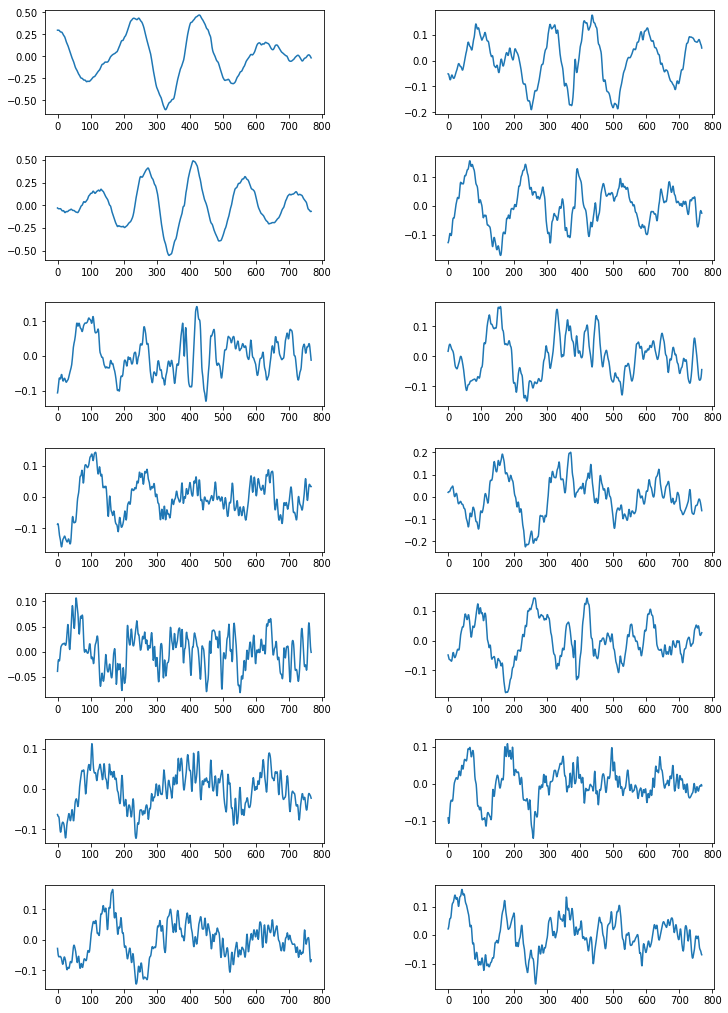

In [143]:
fig = plt.figure(figsize = [12, 18])
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(1, 15):
    ax = fig.add_subplot(7, 2, i)
    ax.plot(corr_eog1[i-1])

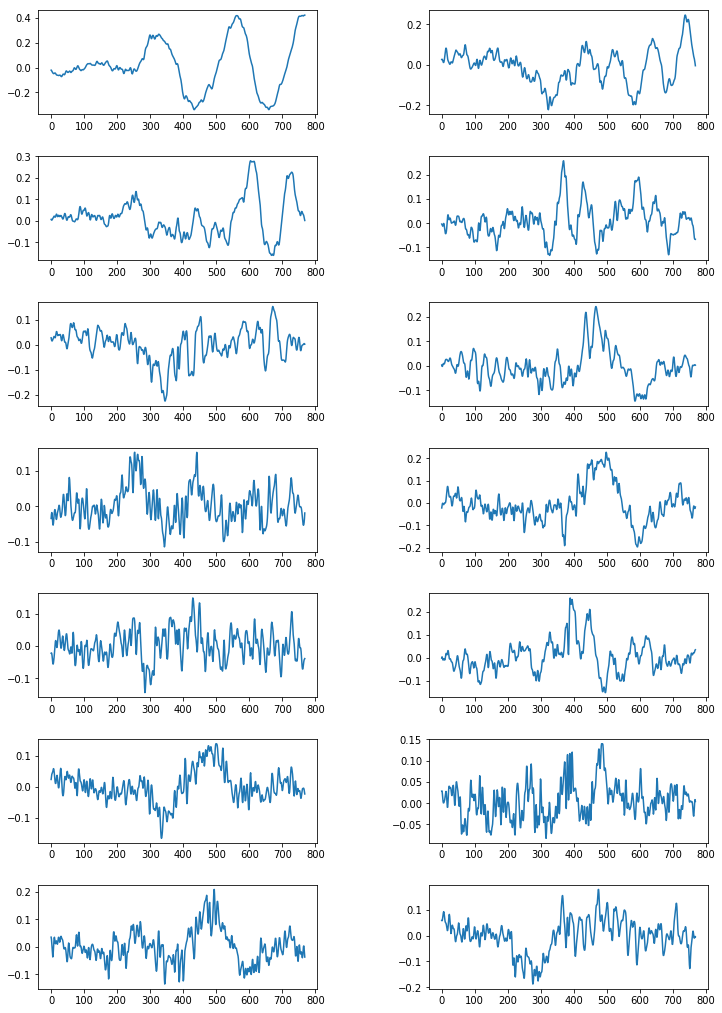

In [175]:
fig = plt.figure(figsize = [12, 18])
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(1, 15):
    ax = fig.add_subplot(7, 2, i)
    ax.plot(corr_eog2[i-1])

In [ ]:
fig = plt.figure(figsize = [12, 18])
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(1, 15):
    ax = fig.add_subplot(7, 2, i)
    ax.plot(t, CORRELATION[28 + i])

In [ ]:
fig = plt.figure(figsize = [12, 18])
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(1, 15):
    ax = fig.add_subplot(7, 2, i)
    ax.plot(t, CORRELATION[42 + i])

In [183]:
for i in range(14):
    print(max(abs(corr_eog1[i])))

0.6043282136315408
0.190043329008559
0.5522454201139082
0.17170739478330363
0.14243820914318747
0.1659995147172695
0.15871565723932937
0.22420816289029602
0.10668963729324174
0.17459562910241314
0.12279651897826079
0.14835967989422819
0.16447578620708833
0.17166551752516543


In [182]:
x = np.diff(corr_eog2a1[3])
rms = np.sqrt(np.mean(x**2))
rms

0.019884816328615787

In [ ]:
COMP[0] = 0